# Example Transit Lightcurve Fitting with Juliet
# TOI 652b
### ObsAstro BONUS task for Group 1

by Tianjun Gan and Sharon Xuesong Wang\
v1 July 2020\
v2 for ET workshop, December 2020
v3 for ObsAstro Spring 2022, May 2022

Please see the imports below for package dependencies.\
I highly recommend installing MultiNest to speed things up!

### Install Juliet

You probably need to install juliet. MultiNest is recommended, but dynesty is enough.

If the pip installation doesn't work for you, you can also download its github package and use python to install it, following the instructions here:\
https://juliet.readthedocs.io/en/latest/user/installation.html

In [392]:
# Uncomment this to install juliet, or do it in your terminal
import sys
# !{sys.executable} -m pip install juliet

In [393]:
import numpy as np
import juliet
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import pickle
import glob
import lightkurve as lk

In [394]:
# Basic constants
tesst0 = 2457000.0  # BJD offset for TESS timestamps

In [395]:
# Function to wrap around juliet's get_TESS_data function to deal with multiple TESS sectors
def juliet_get_tess_data(lkf):
    for indf,thisf in enumerate(lkf):
        thist,thisf,thisferr = juliet.get_TESS_data(thisf)
        if indf == 0:
            t,f,ferr = thist,thisf,thisferr
        else:
            t,f,ferr = np.concatenate((t,thist)), np.concatenate((f,thisf)), \
                np.concatenate((ferr,thisferr))
    
    return t,f,ferr

## Setting up priors from basic planetary parameters

### Instruction:

1. Open up the target page on ExoFOP:  
https://exofop.ipac.caltech.edu/tess/target.php?id=22221375

2. Type in the following numbers in the definition below:  
TIC Contamination Ratio -> contr  
Period of planet 1 -> p1  
Error on period of planet 1 -> perr1  
Transit epoch of planet 1 -> tc1  
Error on transit epoch of planet 1 -> tcerr1  
... similarly for subsequent planets in the system.  

3. Create priors.txt in all appropriate transit fitting folders, the default naming convention for folders are:  
  - transit_fit - Basic transit fit, no detrending.  
  - detrending - Fitting GP to detrend, no transit fitting.  
  - transit_fit_detrended -After detrending with GP, perform transit fit.
  - gp_transit_fit - Joint GP detrending and transit fit.  
  
  **IMPORTANT NAMING CONVENTION:** Name priors.txt for your input priors. Juliet will copy what it used to generate the results into priors.dat so that you can always replicate exactly what you did without worrying about preserving priors.txt.
  
  **Format of priors.txt** see Juliet tutorial here:
https://juliet.readthedocs.io/en/latest/user/quicktest.html  

  **Note:** Be a bit liberal about errors in the priors for planet period and transit epoch. Don't use the error bars from ExoFOP which themselves are from a transit fit!

4. Use the code below to figure out what values to put in for priors for t0 and mdilution_TESS, which is the TESS-offset-adjusted transit time and dilution factor for TESS (1 - contamination ratio). Default is to use 10% of the contamination ratio as the prior width for the dilution factor.

5. Modify priors.txt appropriately.

In [396]:
# Fill in numbers from ExoFOP
contr = 0.002189
p1 = 3.98467677274667  # period in days
perr1 = .000010429663  # error on period in days
tc1 = 2459272.445528  # transit midpoint in full JD unit (begins with 24xxxxx)
tcerr1 = .0022709  # transit midpoint in days

In [397]:
# Print out needed t0 and mdilution_TESS and its prior width.
tc1 -= tesst0
print(tc1)
print(1.0-contr)
print(contr*0.1)

# crude estimate on translated Rp/R* fractional error 
# if too small, fix mdilution_TESS to 1.0
print(np.sqrt(contr*0.1)) 

2272.4455280001275
0.997811
0.0002189
0.01479526951427381


## Download and load in all TESS LCs

In [398]:
# download the lightcurve using lightkurve ;)
# Make sure to change the my_dir to the download folder you want!
my_dir = './'
lkfile = lk.search.search_lightcurvefile('TOI 652', mission='TESS')
lkf = lkfile.download_all(download_dir=my_dir)

In [399]:
# juliet needs the fits file
import os
lkf = glob.glob(os.path.join(my_dir, 'mastDownload/*/*/tess*.fits'))
print(lkf)

['./mastDownload/TESS/tess2019058134432-s0009-0000000022221375-0139-s/tess2019058134432-s0009-0000000022221375-0139-s_lc.fits', './mastDownload/TESS/tess2021039152502-s0035-0000000022221375-0205-s/tess2021039152502-s0035-0000000022221375-0205-s_lc.fits']


In [400]:
t,f,ferr = juliet_get_tess_data(lkf)

(1544.24067510321, 2279.9834295852534)

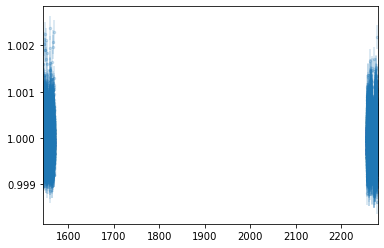

In [401]:
# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

# Plot data:
plt.errorbar(t,f, yerr=ferr, fmt='.',alpha=0.2)
plt.xlim([np.min(t),np.max(t)])

## Need to detrend?

If upon visual inspection, the LC needs a detrending, then perform GP fit as below with transits blocked out.

You first need to make a text file that stores your priors, and pass this file (and the priors) to juliet. Create a folder in your directory called "detrending", and make a priors.txt with contents as follows:

mdilution_TESS          fixed                   1.0  
mflux_TESS              normal                  0.0,0.1  
sigma_w_TESS            loguniform              1e-6,1e6  
GP_sigma_TESS           loguniform              1e-6,1e6  
GP_rho_TESS             loguniform              1e-3,1e3  

In [402]:
# First, block out the transits
# Get phases --- identify out-of-transit (oot) times by phasing the data
# and selecting all points at absolute phases larger than 0.02:
phases = juliet.utils.get_phases(t, p1, tc1)
idx_oot = np.where(np.abs(phases)>0.02)[0]
# Save the out-of-transit data into dictionaries so we can feed them to juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot],f[idx_oot],ferr[idx_oot]

### Make sure you have the prior file path below correct first!

You should have your prior file ready: ./detrending/priors.txt

In [403]:
# Perform the juliet fit. Load dataset first (note the GP regressor will be the times):
dataset = juliet.load(priors='./detrending/priors.txt', t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, GP_regressors_lc = times, \
                      out_folder = './detrending/')

In [404]:
# Fit:
# Need to delete the posteriors.pkl file to re-run the fit.
results = dataset.fit()
# This took a couple minutes.

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./detrending/_dynesty_NS_posteriors.pkl


(1544.24067510321, 2279.9834295852534)

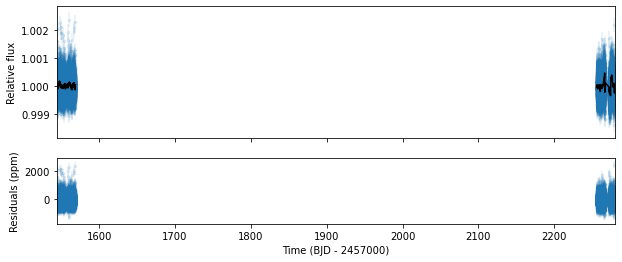

In [405]:
# Get model to visually check
model_fit = results.lc.evaluate('TESS')

# Plot:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])

# First the data and the model on top:
ax1 = plt.subplot(gs[0])
ax1.errorbar(times['TESS'], fluxes['TESS'], fluxes_error['TESS'],fmt='.',alpha=0.1)
ax1.plot(times['TESS'], model_fit, color='black', zorder=100)
ax1.set_ylabel('Relative flux')
ax1.set_xlim(np.min(times['TESS']),np.max(times['TESS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Now the residuals:
ax2 = plt.subplot(gs[1])
ax2.errorbar(times['TESS'], (fluxes['TESS']-model_fit)*1e6, \
             fluxes_error['TESS']*1e6,fmt='.',alpha=0.1)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD - 2457000)')
ax2.set_xlim(np.min(times['TESS']),np.max(times['TESS']))

In [406]:
# Get juliet model prediction for the full lightcurve:
model_prediction = results.lc.evaluate('TESS', t = t, GPregressors = t)
# this is the general trend you want to remove from the TESS light curve

# Repopulate dictionaries with new detrended flux:
# Think about how you want to detrend the light curve, and scale the errors in flux as well
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot], (f/model_prediction)[idx_oot], \
            (ferr/model_prediction)[idx_oot]

In [407]:
fnew = f/model_prediction#(f-model_prediction)/f.mean()
print(float('nan') in fnew)

False


## Perform transit fit

Perhaps on the detrended LC, as needed per previous section.  
All definition of parameters should carry over even if previous section on detrending does not exist.


### Set up the priors

Just like detrending, you need to set up your priors. This time, it is in the provided priors.txt file (please don't mix this with your detrending prior!). However, you will need to modify a few parameters there in order for the fit to converge easily. Look up the values and their error bars for these parameters below on ExoFOP, and change them in the priors.txt file accordingly:

P_p1 - period for planet 1
t0_p1 - transit middle time, Tc 
rho - stellar density, please note the unit! Should be in km/m3, not g/cm3 as in ExoFOP. 

The widths of these priors should be a bit larger (e.g., a factor of 2) than the error bars listed on ExoFOP to allow flexibility.


### Again mind the file paths!

After you've correctly set up the prior files, the codes below should just run smoothly (i.e., no more ??? for you to fill in - just read the code to get a feel of it). If not, you may want to check to see if your detrending is ok, or if you want to have better priors to help the model converge.

In [408]:
dataset = juliet.load(priors='./transit_fit_detrended/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = './transit_fit_detrended/')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.


ValueError: The log-likelihood (nan) of live point 0 located at u=[0.24741666 0.30197587 0.72377147 0.85918108 0.06399413 0.24121174
 0.77751412 0.91172303 0.40588844] v=[3.98417425e+00 1.54319813e+03 7.23771471e-01 8.59181084e-01
 6.39941333e-02 2.41211739e-01 6.54299352e+02 1.35144185e-01
 4.20294540e+00]  is invalid.

In [ ]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_ylim([0.998,1.002])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black',zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.998,1.002])
ax2.set_xlabel('Phases')

: 

: 

: 

: 

## Produce posteriors for impact parameter b and planet-star radius ratio

Juliet fits the transit parameters in a converted space, with no direct parameter on star-planet radius ratio, so we need to convert them. Please see the Juliet paper and documentation for more.

In [ ]:
# unpack the pickle file
infile = open('./transit_fit_detrended/posteriors.pkl','rb')
posteriors = pickle.load(infile)
infile.close()

: 

: 

: 

: 

In [ ]:
# extract r1 and r2
r1, r2 = posteriors['posterior_samples']['r1_p1'],\
         posteriors['posterior_samples']['r2_p1']

: 

: 

: 

: 

In [ ]:
# Transform back to (b,p):
b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

: 

: 

: 

: 

In [ ]:
# Plot posterior distribution:
plt.plot(b,p,'.',alpha=0.5)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 